# Profile KMeans

In [58]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Running on the Remote

On MPSD:
```
tmux new -s jlab
source programs/isdfBenchmarks/.venv/bin/activate
jupyter lab --no-browser --ip=0.0.0.0 --port 8888
```

Detach with `Ctrl-b d`
Reattach with: `tmux attach -t jlab`
Paste the Jupyter URL into `Settings > Jupyter > Jupyter Servers > Configured servers`
and save the token proceeding the URL, ask Pycharm will ask for it


### Generate Inputs

kmeans with L2 norm

* Call `jobs/kmeans_profiling.py` locally, then SCP the inputs across
*   Submitted batch job 283930 for anthracene, as a test
*   Submit the rest in `/home/bucchera/exchange_calcs/kmeans_l2`


### Job Intermediates

* chlorophyll needs a psuedo-set with Mg in it, so should change from
   the default. Find one of my older input files, then re-run it
  * `home/bucchera/exchange_calcs/kmeans_ref/chlorophyll`
  * `/home/bucchera/exchange_calcs/kmeans_l2/chlorophyll`
    
* Buckerminster runs the first kmeans, then falls over for some reason
  * Also seems to be using ELPA
  * Need to re-run it with `Debug=trace`
  * `/home/bucchera/exchange_calcs/kmeans_ref/buckminster`


In [59]:
""" Reference Data using the Algorithm in Main
"""
from pathlib import Path

from isdfbenchmarks.parser.profiling import parse_time

# Parse ISDF profiling times, including kmeans. KMeans runs for every iteration
results_root = Path("/home/bucchera/exchange_calcs/kmeans_ref")
directories =  ["anthracene", "tetracene", "pentacene", "ether_crown"]

isdf_results = {}
for dir in directories:
    cumulative, self = parse_time(results_root / dir / "profiling/time.000000")
    isdf_results[dir] = {'cumulative': cumulative, 'self':self}


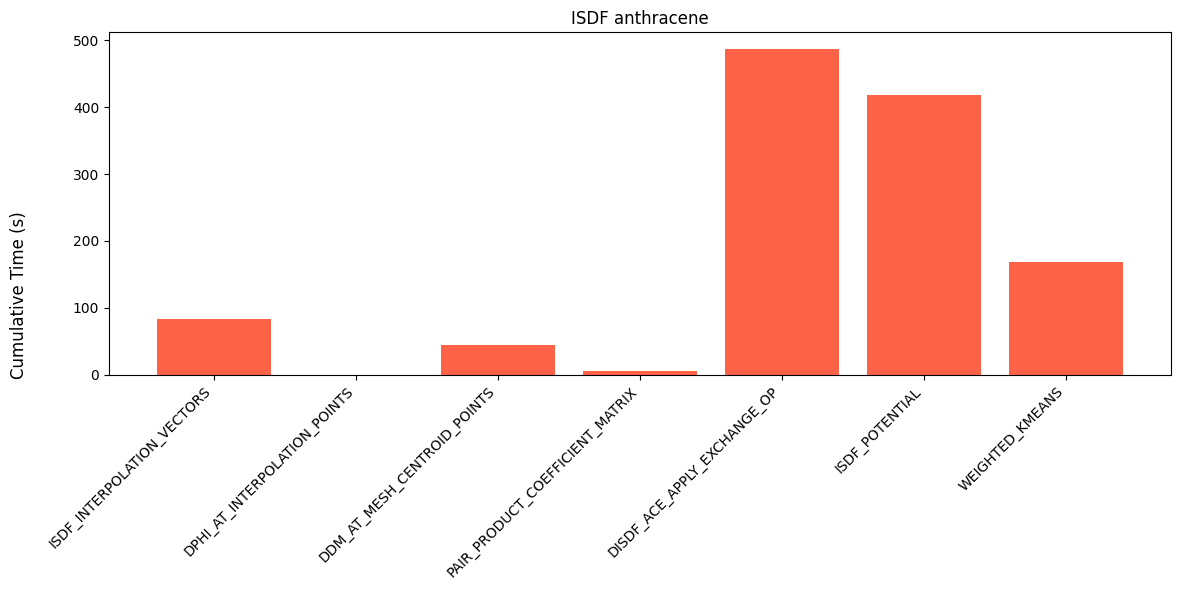

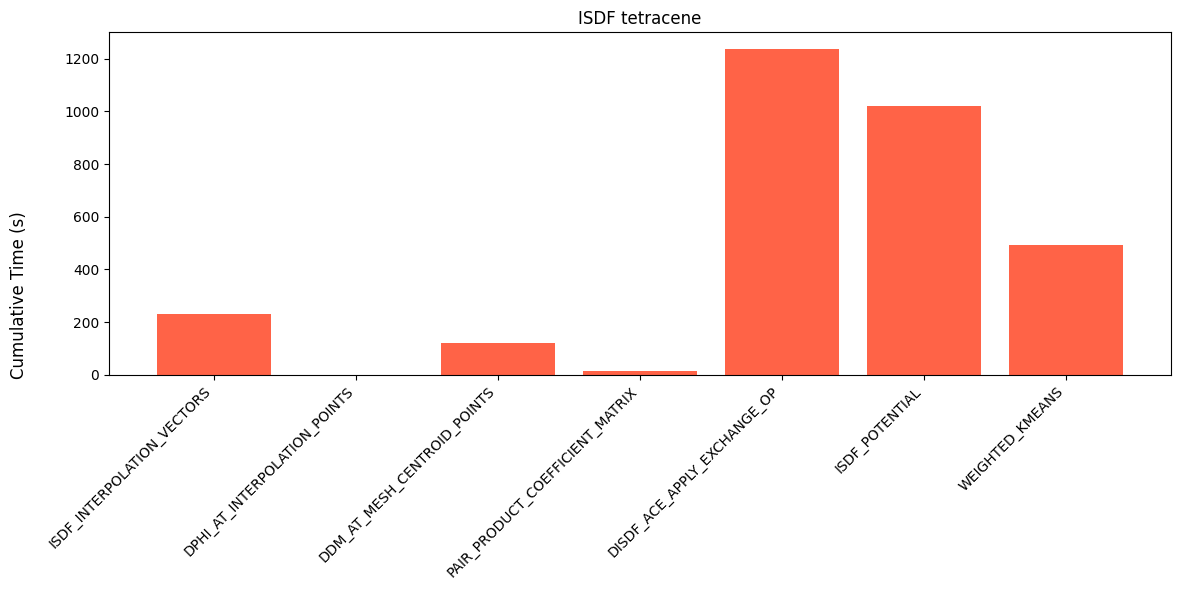

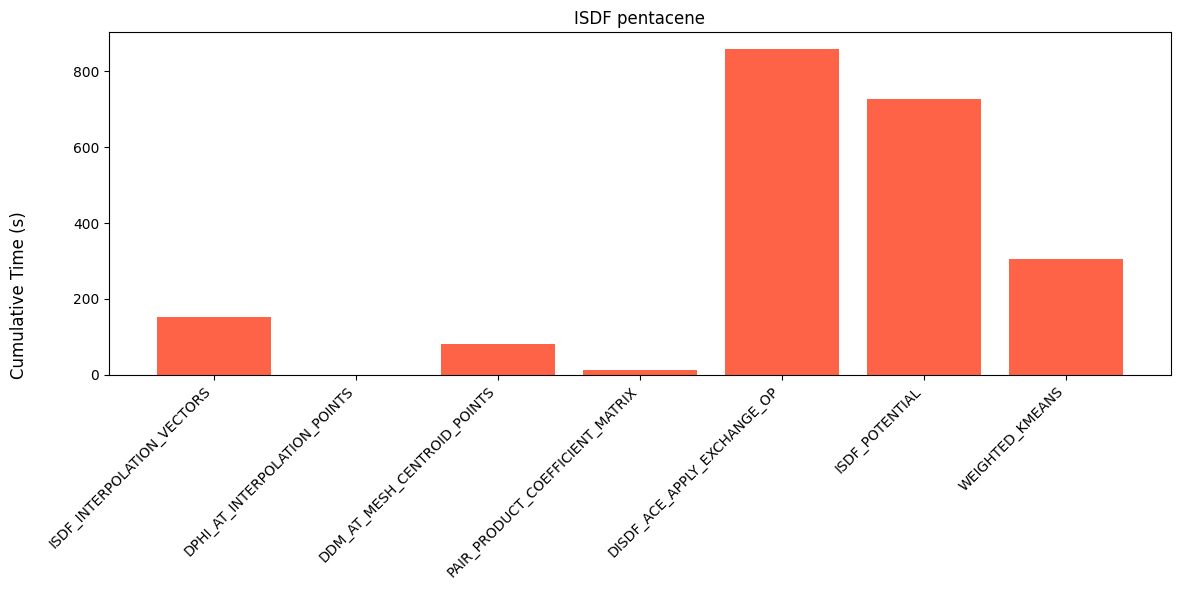

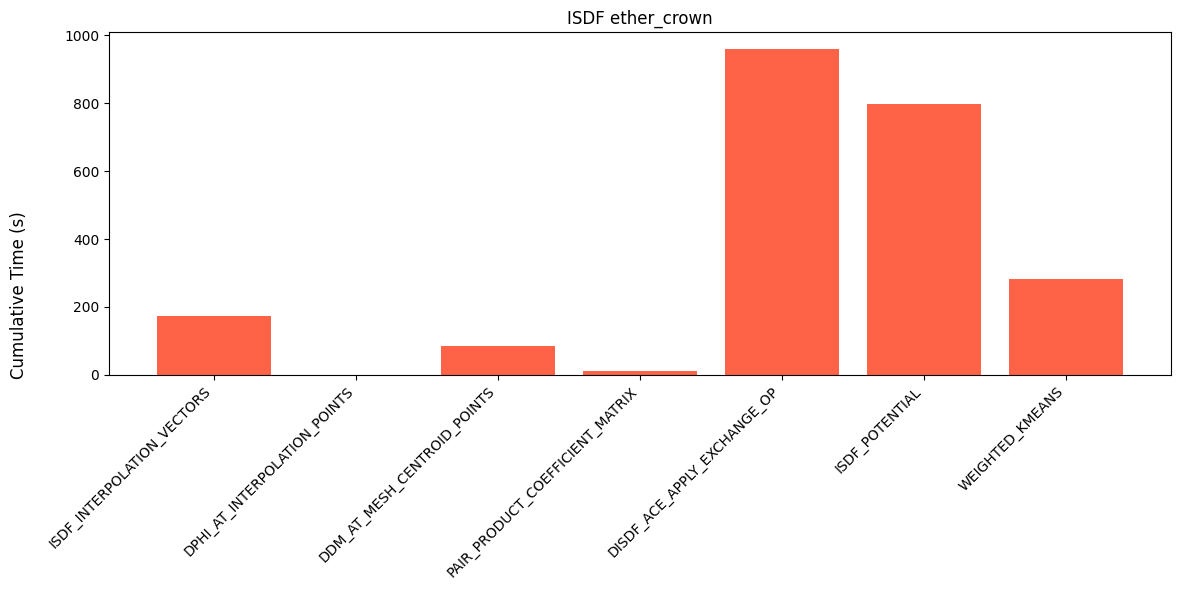

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Functions
def add_bars(ax, labels, values, *, label=None, color=None, width=0.8, rot=45):
    x = np.arange(len(labels))
    ax.bar(x, values, width=width, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rot, ha='right')
    if label:
        ax.legend()
    return ax

to_total_time = lambda t, routines: [t[name]['TOTAL_TIME'] for name in routines]
to_time_per_call = lambda t, routines: [t[name]['TIME_PER_CALL'] for name in routines]

# Extract times of relevant routines
isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL',
            'WEIGHTED_KMEANS']

# Plotting.
for dir in directories:
    fig, ax_isdf = plt.subplots(1, 1, figsize=(12, 6), sharey=True)
    add_bars(ax_isdf, isdf_routines, to_total_time(isdf_results[dir]['cumulative'], isdf_routines), color='tomato')
    ax_isdf.set_title(f'ISDF {dir}')
    fig.supylabel('Cumulative Time (s)')
    fig.tight_layout()

In [61]:
""" Parser function definitions
"""
import numpy as np
import re
from typing import List

from isdfbenchmarks.parser import static
from isdfbenchmarks.parser.stdout import parse_exchange_energy


def parse_kmeans_iterations(path) -> List[int]:
    pat = re.compile(r'^Kmeans converged in\s+(\d+)\s+iterations\b',
                     re.IGNORECASE | re.MULTILINE)
    
    with open(path, "r", encoding="utf-8") as fid:
        text = fid.read()
    
    # All iteration counts as ints
    return np.array([int(n) for n in pat.findall(text)])


def parse_kmeans_set(root, directories) -> dict:
    iters = {}
    for dir in directories:
        iters[dir] = parse_kmeans_iterations(root / dir / "terminal.out")
    return iters


def parse_exx(root, directories) -> dict:
    """ Parse the final exact exchange energy from a calculation
    :param root: 
    :param directories: 
    :return: 
    """
    exx = {}
    for dir in directories:
        exx[dir] = static.info_file(root / dir)['Energy']['Exchange']
    return exx


def parse_exx_convergence(root: Path, directories: list) -> dict:
    exx_convergence = {}
    for dir in directories:
        with open(root / dir / "terminal.out", "r", encoding="utf-8") as fid:
            text = fid.read()
        exx_convergence[dir] = np.array([e for e in parse_exchange_energy(text).values()])
    return exx_convergence


In [62]:
""" Define the root directories for each set of calculations, and the data set
"""
root_ace_ref = Path("/home/bucchera/exchange_calcs/ace_references")
root_kmeans_ref = Path("/home/bucchera/exchange_calcs/kmeans_ref")
root_kmeans_l2 = Path("/home/bucchera/exchange_calcs/kmeans_l2")
root_kmeans_l2_preassign = Path("/home/bucchera/exchange_calcs/kmeans_l2_and_preassign")
root_kmeans_l2_inertia = Path("/home/bucchera/exchange_calcs/kmeans_l2_and_inertia")

molecules =  ["anthracene", "tetracene", "pentacene", "ether_crown"]

In [63]:
""" Parse:
 Convergence in KMeans as a function of SCF Iteration
 final exact exchange energy
 Parse convergence in exact exchange energy
"""

# Iterations
ref_iters = parse_kmeans_set(root_kmeans_ref, molecules)
l2_iters = parse_kmeans_set(root_kmeans_l2, molecules)
l2_preassign_iters = parse_kmeans_set(root_kmeans_l2_preassign, molecules)
l2_inertia_iters = parse_kmeans_set(root_kmeans_l2_inertia, molecules)


# Converged exact exchange energies, per molecule
ref_ace_exx = parse_exx(root_ace_ref, molecules)
# ISDF exact exchange energies
ref_exx = parse_exx(root_kmeans_ref, molecules)
l2_exx = parse_exx(root_kmeans_l2, molecules)
l2_preassign_exx = parse_exx(root_kmeans_l2_preassign, molecules)
l2_inertia_exx = parse_exx(root_kmeans_l2_inertia, molecules)


# EXX as a function of SCF
ref_exx_convergence = parse_exx_convergence(root_kmeans_ref, molecules)
l2_exx_convergence = parse_exx_convergence(root_kmeans_l2, molecules)
l2_preassign_exx_convergence = parse_exx_convergence(root_kmeans_l2_preassign, molecules)
l2_inertia_exx_convergence = parse_exx_convergence(root_kmeans_l2_inertia, molecules)


In [64]:
""" Plot:
* Convergence in KMeans as a function of SCF Iteration
* Convergence in EXX as a function of SCF Iteration
"""
import matplotlib.pyplot as plt

# Combined in the next cell
plot_me = False

if plot_me:
    
    # Convergence in KMeans as a function of SCF Iteration
    for molecule in molecules:
        plt.plot(np.arange(len(ref_iters[molecule]), dtype=int), ref_iters[molecule], 'ro--', linewidth=2, markersize=8, label='Ref')
        plt.plot(np.arange(len(l2_iters[molecule]), dtype=int), l2_iters[molecule], 'bo--', linewidth=2, markersize=8, label='L2 Norm')
        plt.xlabel("SCF Iteration")
        plt.ylabel("Number of Kmeans Iterations")
        plt.title(molecule)
        plt.legend()
        plt.show()
    
    
    # Also show convergence in the total energy
    for molecule in molecules:
        plt.plot(np.arange(len(ref_exx_convergence[molecule]), dtype=int), ref_exx_convergence[molecule], 
                 'ro--', linewidth=2, markersize=8, label='Ref')
        plt.plot(np.arange(len(l2_exx_convergence[molecule]), dtype=int), l2_exx_convergence[molecule], 
                 'bo--', linewidth=2, markersize=8, label='L2 Norm')
        plt.xlabel("SCF Iteration")
        plt.ylabel("Exact Exchange Energy (Ha)")
        plt.title(molecule)
        plt.legend()
        plt.show()



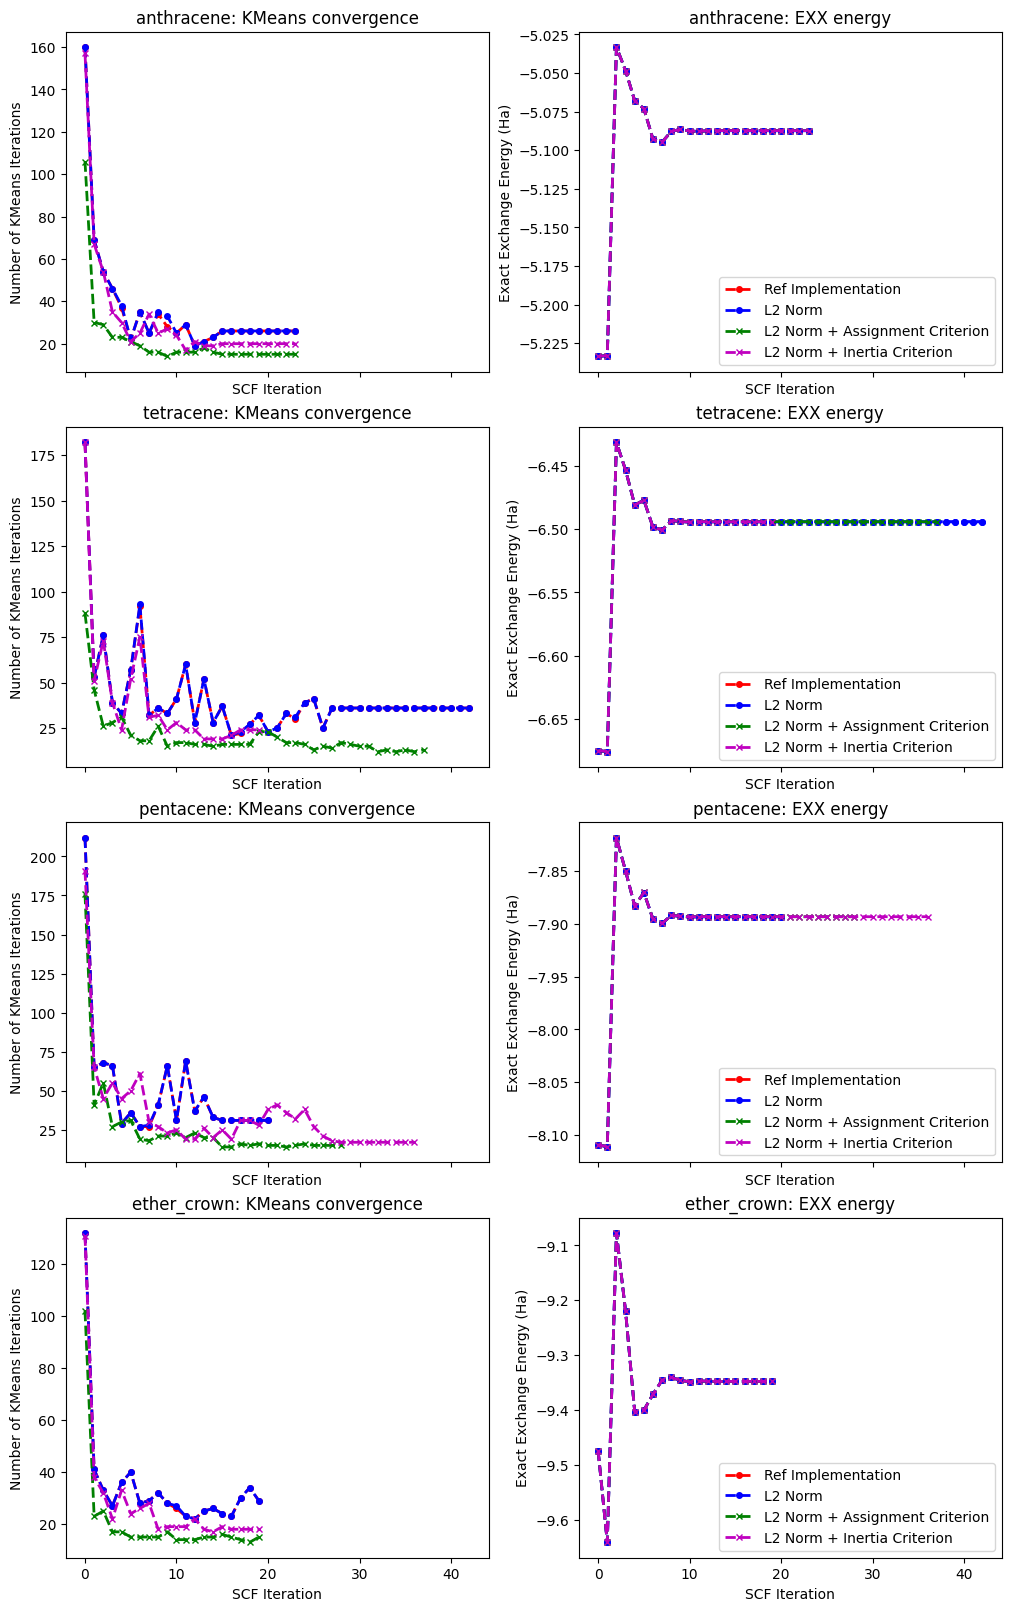

In [106]:
"""Same as the above, but combined into (n_molecules, 2) subplot
"""
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    nrows=len(molecules), ncols=2, figsize=(10, 4 * len(molecules)), 
    sharex='col', constrained_layout=True
)

# If there's only one molecule, axes comes back as a 1D array; normalize to 2D
if len(molecules) == 1:
    axes = np.array([axes])

for i, molecule in enumerate(molecules):
    ax_left, ax_right = axes[i, 0], axes[i, 1]

    # --- Left: KMeans iterations vs SCF iteration ---
    x_ref = np.arange(len(ref_iters[molecule]), dtype=int)
    x_l2  = np.arange(len(l2_iters[molecule]), dtype=int)
    x_l2_preassign = np.arange(len(l2_preassign_iters[molecule]), dtype=int)
    x_l2_inertia = np.arange(len(l2_inertia_iters[molecule]), dtype=int)

    ax_left.plot(x_ref, ref_iters[molecule], 'ro--', linewidth=2, markersize=4, label='Ref Implementation')
    ax_left.plot(x_l2, l2_iters[molecule],  'bo--', linewidth=2, markersize=4, label='L2 Norm')
    ax_left.plot(x_l2_preassign, l2_preassign_iters[molecule],  'gx--', linewidth=2, markersize=4, label='L2 Norm + Assignment Criterion')
    ax_left.plot(x_l2_inertia, l2_inertia_iters[molecule],  'mx--', linewidth=2, markersize=4, label='L2 Norm + Inertia Criterion')

    ax_left.set_xlabel("SCF Iteration")
    ax_left.set_ylabel("Number of KMeans Iterations")
    ax_left.set_title(f"{molecule}: KMeans convergence")

    # --- Right: Exact exchange energy vs SCF iteration ---
    x_ref_e = np.arange(len(ref_exx_convergence[molecule]), dtype=int)
    x_l2_e  = np.arange(len(l2_exx_convergence[molecule]), dtype=int)
    x_l2_preassign_e = np.arange(len(l2_preassign_exx_convergence[molecule]), dtype=int)
    x_l2_inertia_e = np.arange(len(l2_inertia_exx_convergence[molecule]), dtype=int)
    
    ax_right.plot(x_ref_e,  ref_exx_convergence[molecule],  'bo--', linewidth=2, markersize=4, label='Ref')
    ax_right.plot(x_l2_e,  l2_exx_convergence[molecule],  'bo--', linewidth=2, markersize=4, label='L2 Norm')
    ax_right.plot(x_l2_preassign_e, l2_preassign_exx_convergence[molecule], 'gx--', linewidth=2, markersize=4, 
                  label='L2 Norm + Assignment Criterion')
    ax_right.plot(x_l2_inertia_e, l2_inertia_exx_convergence[molecule], 'mx--', linewidth=2, markersize=4, 
                  label='L2 Norm + Inertia Criterion')

    ax_right.set_xlabel("SCF Iteration")
    ax_right.set_ylabel("Exact Exchange Energy (Ha)")
    ax_right.set_title(f"{molecule}: EXX energy")
    # Legend for right plot
    handles, labels = axes[0, 0].get_legend_handles_labels()
    ax_right.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.00, 0.00), ncol=1, frameon=True)


save_image = True
if save_image:
    # Remote path
    file = Path.cwd() / "programs/isdfBenchmarks/jupyter/images"
    plt.savefig(file / "criteria_on_convergence.png", dpi=300, bbox_inches="tight")

plt.show()


calc smaller
calc smaller
calc smaller


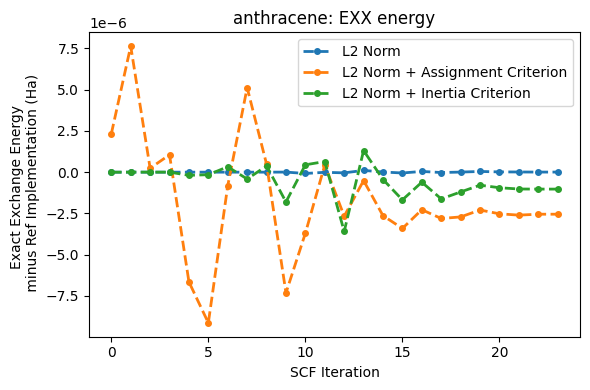

calc smaller
calc smaller
calc smaller


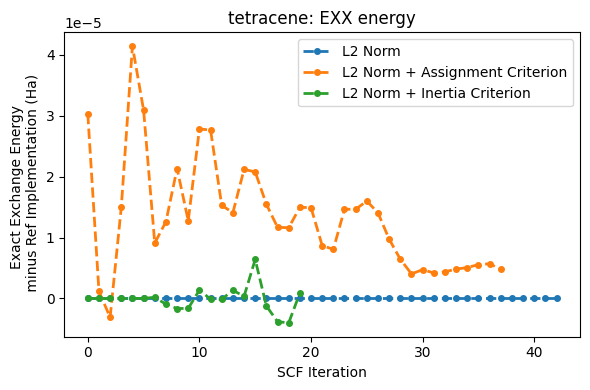

calc smaller
Ref smaller
29 29
Ref smaller
37 37


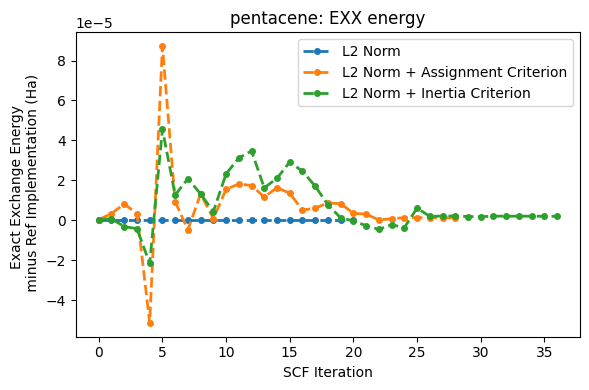

calc smaller
calc smaller
calc smaller


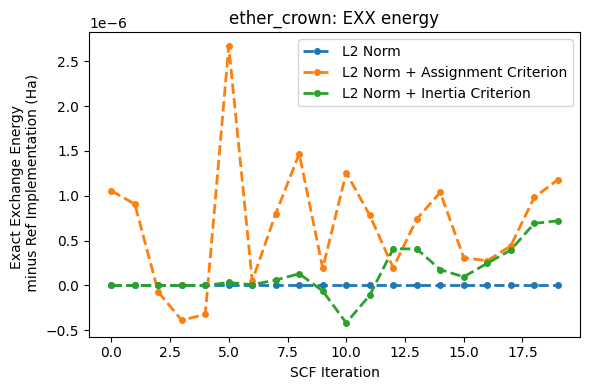

In [120]:
"""Same as the above, but combined into (n_molecules, 2) subplot
"""
import numpy as np
import matplotlib.pyplot as plt


# Plot differences w.r.t. the reference implementation
def set_x_y_data(ref_exx_convergence, calc_exx_convergence):
    """
    
    :param ref_exx_convergence: 
    :param calc_exx_convergence: 
    :return: 
    """
    l_ref = len(ref_exx_convergence)
    l_kmeans = len(calc_exx_convergence)
    
    # Number of SCF iterations corresponds to the length 
    x = np.arange(l_kmeans, dtype=int)

    # If the kmeans change took more iterations, pad the reference data
    if l_ref < l_kmeans:
        padding = [ref_exx_convergence[-1]]* (l_kmeans - l_ref)
        ref = np.r_[ref_exx_convergence, padding] 
    else:
        # If the reference took the same or more, truncate it to the kmeans change
        ref = ref_exx_convergence
    
    y = np.asarray(calc_exx_convergence)[start:l_kmeans] - np.asarray(ref)[start:l_kmeans]

    return x, y 


start = 0

for molecule in molecules:
    fig, ax = plt.subplots(figsize=(6, 4))

    x, y = set_x_y_data(ref_exx_convergence[molecule], l2_exx_convergence[molecule])
    ax.plot(x, y, marker='o', linestyle='--', linewidth=2, markersize=4, label='L2 Norm')

    x, y = set_x_y_data(ref_exx_convergence[molecule], l2_preassign_exx_convergence[molecule])
    ax.plot(x, y, marker='o', linestyle='--', linewidth=2, markersize=4, label='L2 Norm + Assignment Criterion')

    x, y = set_x_y_data(ref_exx_convergence[molecule], l2_inertia_exx_convergence[molecule])
    ax.plot(x, y, marker='o', linestyle='--', linewidth=2, markersize=4, label='L2 Norm + Inertia Criterion')

    ax.set_xlabel("SCF Iteration")
    ax.set_ylabel("Exact Exchange Energy \n minus Ref Implementation (Ha)")
    ax.set_title(f"{molecule}: EXX energy")
    ax.legend(loc='upper right', ncol=1, frameon=True)

    fig.tight_layout()
    
    save_image = True
    if save_image:
        # Remote path
        file = Path.cwd() / "programs/isdfBenchmarks/jupyter/images"
        plt.savefig(file / f"kmeans_effect_on_exx_{molecule}.png", dpi=300, bbox_inches="tight")
        
    plt.show()



### Discussion

**Use of L2 Norm**

The initial comparison to data in `mpi_isdf` for anthracene showed the converged EXX was the same with the L2 criterion (within some error), but the SCF convergence differed. This was either due to a different grid spacing, or a different number of ISDF points used - I didn't check as that is not the point of this analysis
 
Comparison of equivalent data sets, which differ only in the use of the L2 norm criterion, do not differ at all w.r.t. the final exchange energy, and on the whole, it looks like using L2 fractionally increases the number of kmeans iterations in some cases. 


**Use of L2 Norm + Inertia**

The result for pentacene is initially unusal. The L2 criterion always gets evaluated first, so worst-case should have been the convergence associated with just using the L2 norm... unless the inertia criterion was effective in stopping kmeans in earlier SCF steps, resulting in a slightly different set of centroids.


Error is in (Ha) but not scaled to per atom
Errors for anthracene [2.518e-05 2.519e-05 2.263e-05 2.519e-05]
Errors for tetracene [7.653e-05 7.653e-05 8.098e-05 7.653e-05]
Errors for pentacene [0.00020796 0.00020796 0.00020922 0.00020796]
Errors for ether_crown [1.599e-05 1.599e-05 1.717e-05 1.599e-05]


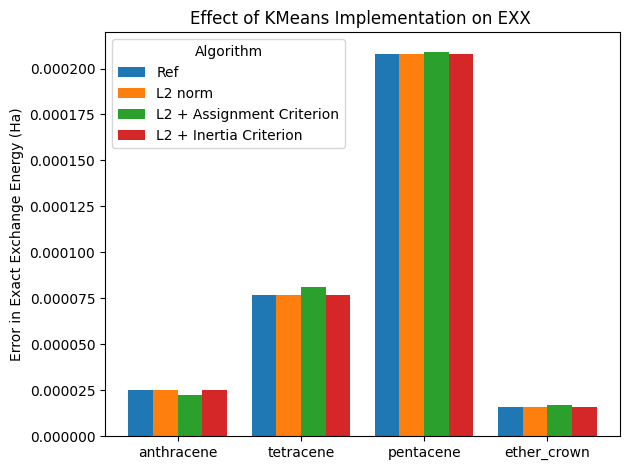

In [75]:
""" Plot Error in EXX for each KMeans implementation
"""
# Convert exx to relative errors w.r.t. ACE benchmark
delta_exx = {}

print("Error is in (Ha) but not scaled to per atom")
for molecule in molecules:
    delta_exx[molecule] = np.array([np.abs(ref_exx[molecule] - ref_ace_exx[molecule]),   # Ref
                                    l2_exx[molecule] - ref_ace_exx[molecule],            # L2 norm
                                    l2_preassign_exx[molecule] - ref_ace_exx[molecule],  # L2 norm plus grid assignment criterion
                                    l2_exx[molecule] - ref_ace_exx[molecule]             # L2 norm plus inertia criterion
                                    ]      
                                   )
    print(f"Errors for {molecule}", delta_exx[molecule])

# Bar plot setup
labels = list(delta_exx.keys()) 
vals = np.vstack([delta_exx[k] for k in labels])
n_groups, n_bars = vals.shape

x = np.arange(n_groups)                         # group positions
group_width = 0.8                               # total width occupied by each group
bar_width = group_width / n_bars

# center the block of bars on each group tick
offsets = (np.arange(n_bars) - (n_bars - 1) / 2) * bar_width

kmeans_algo = ['Ref', 'L2 norm', 'L2 + Assignment Criterion', 'L2 + Inertia Criterion']
for i in range(n_bars):
    plt.bar(x + offsets[i], vals[:, i], width=bar_width, label=f'{kmeans_algo[i]}')

plt.xticks(x, labels, rotation=0)
plt.ylabel('Error in Exact Exchange Energy (Ha)')
plt.title('Effect of KMeans Implementation on EXX ')
plt.legend(title='Algorithm')
plt.tight_layout()


In [94]:
# Parse ISDF profiling times, including kmeans. KMeans runs for every iteration

from pathlib import Path

from isdfbenchmarks.parser.profiling import parse_time

# Extract times of relevant routines
kmeans_routines = ['DDM_AT_MESH_CENTROID_POINTS',
            'ASSIGN_POINTS_TO_CENTROIDS_FINITE_BC',
            'WEIGHTED_KMEANS']

routine =  'WEIGHTED_KMEANS'

timings = {}
for molecule in directories:
    # parse time returns (cumulative, self)
    timings[molecule] = np.array([ parse_time(root_kmeans_ref / molecule / "profiling/time.000000")[0][routine]['TOTAL_TIME'],
                                   parse_time(root_kmeans_l2 / molecule / "profiling/time.000000")[0][routine]['TOTAL_TIME'],
                                   parse_time(root_kmeans_l2_preassign / molecule / "profiling/time.000000")[0][routine]['TOTAL_TIME'],
                                   parse_time(root_kmeans_l2_inertia / molecule / "profiling/time.000000")[0][routine]['TOTAL_TIME']
                                ])

{'anthracene': array([168.376523, 155.334926, 106.21796 , 140.889872]), 'tetracene': array([493.662375, 451.222343, 232.027818, 208.643827]), 'pentacene': array([306.168286, 282.783012, 292.916284, 453.733781]), 'ether_crown': array([281.04067 , 260.360251, 175.447131, 221.078008])}


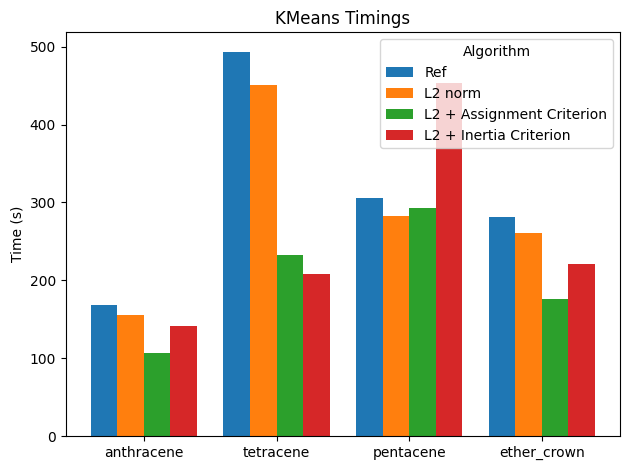

In [101]:
""" Plot timings for KMeans implementation
"""

print(timings)

# Bar plot setup
labels = list(timings.keys()) 
vals = np.vstack([timings[k] for k in labels])
n_groups, n_bars = vals.shape

x = np.arange(n_groups)                         # group positions
group_width = 0.8                               # total width occupied by each group
bar_width = group_width / n_bars

# center the block of bars on each group tick
offsets = (np.arange(n_bars) - (n_bars - 1) / 2) * bar_width

kmeans_algo = ['Ref', 'L2 norm', 'L2 + Assignment Criterion', 'L2 + Inertia Criterion']
for i in range(n_bars):
    plt.bar(x + offsets[i], vals[:, i], width=bar_width, label=f'{kmeans_algo[i]}')

plt.xticks(x, labels, rotation=0)
plt.ylabel('Time (s)')
plt.title('KMeans Timings')
plt.legend(title='Algorithm')
plt.tight_layout()

save_image = True
if save_image:
    # Remote path
    file = Path.cwd() / "programs/isdfBenchmarks/jupyter/images"
    plt.savefig(file / f"kmeans_timings.png", dpi=300, bbox_inches="tight")

### Discussion

Got the criterion wrong. Using 10%, not 0.1%. Hence why the effect is so large. Fix the binary and resubmit. 

Let's see if the inertia does the same job, but better


In [ ]:
"""Remaining Data Analysis and Runs
"""
# Should also compare profilings for each implementation. 
# * Might be that L2 takes longer without reducing iterations
# * Might be that inertia takes MUCH longer than the empirical Lin Lin criterion
# HOWEVER, both L2 and inertia might also increase the robustness in the algorithm in comparison to the reference, which I'm just not currently testing for
# For each case, it might be worth tuning the hyper-parameters:
#  * Rel tol of L2
#  * Number of iterations with no changed to be considered "stable"

# For now, probably the most important thing to do is improve the initial seeding, to optimise the choice of points.